In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp

from reduced_open_es import ReducedOpenES
from evosax import ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.problems import GymnaxFitness

def make_train(config):

    def train(commsize, rng):

        # INIT NETWORK
        network = NetworkMapper["MLP"](
            num_hidden_units=64,
            num_hidden_layers=2,
            num_output_units=2,
            hidden_activation="relu",
            output_activation="categorical",
        )
        pholder = jnp.zeros((4,))
        params = network.init(
            rng,
            x=pholder,
            rng=rng,
        )

        param_reshaper = ParameterReshaper(params)

        evaluator = GymnaxFitness(config["ENV_NAME"], num_env_steps=config["NUM_ENV_STEPS"], num_rollouts=config["NUM_ROLLOUTS"])
        evaluator.set_apply_fn(network.apply)
        rng, _rng = jax.random.split(rng)
        strategy = ReducedOpenES(popsize=config["POP_SIZE"],
                num_dims=param_reshaper.total_params,
                opt_name="adam",
                lrate_init=config["L_RATE_INIT"],
                commsize=commsize,
                horizon_length=config["HORIZON_LENGTH"],
                rng = _rng,
                num_gens=config["NUM_GENERATIONS"])
        strategy.default_params

        fit_shaper = FitnessShaper(centered_rank=True,
                                w_decay=config["W_DECAY"],
                                maximize=True)


        def _update_gen(carry, unused):
            rng, state = carry
            rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
            x, state = strategy.ask(rng_ask, state)
            reshaped_params = param_reshaper.reshape(x)
            fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
            fit_re = fit_shaper.apply(x, fitness)
            state = strategy.tell(x, fit_re, state)
            carry = (rng, state)
            return carry, fitness
        
        state = strategy.initialize(rng)
        carry = (rng, state)
        state, fitness = jax.lax.scan(_update_gen, carry, None, config["NUM_GENERATIONS"])
        return state, fitness

    return train

In [3]:
config = {
    "ENV_NAME": "CartPole-v1",
    "NUM_ENV_STEPS": 200,
    "NUM_ROLLOUTS": 1,
    "POP_SIZE": 90,
    "L_RATE_INIT": 0.1,
    "NUM_GENERATIONS": 100,
    "W_DECAY": 0.0,
    # "COMMSIZE":50,
    "HORIZON_LENGTH":10
}
ms = [m for m in range(0,100,10)]
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 128)
# train=make_train(config)
# outs=train(50,rng)
train_vvjit = jax.jit(
    jax.vmap(
        jax.vmap(
            make_train(config), in_axes=(0, None)
        ), in_axes=(None, 0)
    )
)
outs = train_vvjit(jnp.array(ms),rngs)

ParameterReshaper: 4610 parameters detected for optimization.


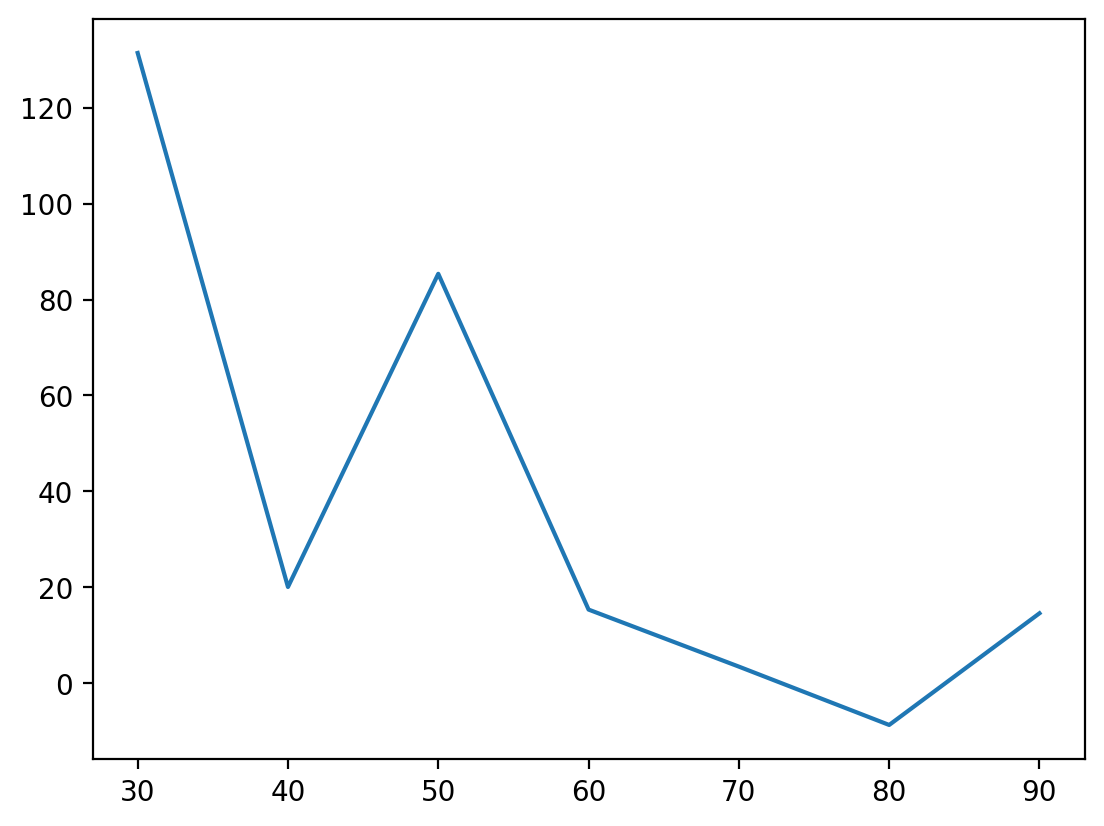

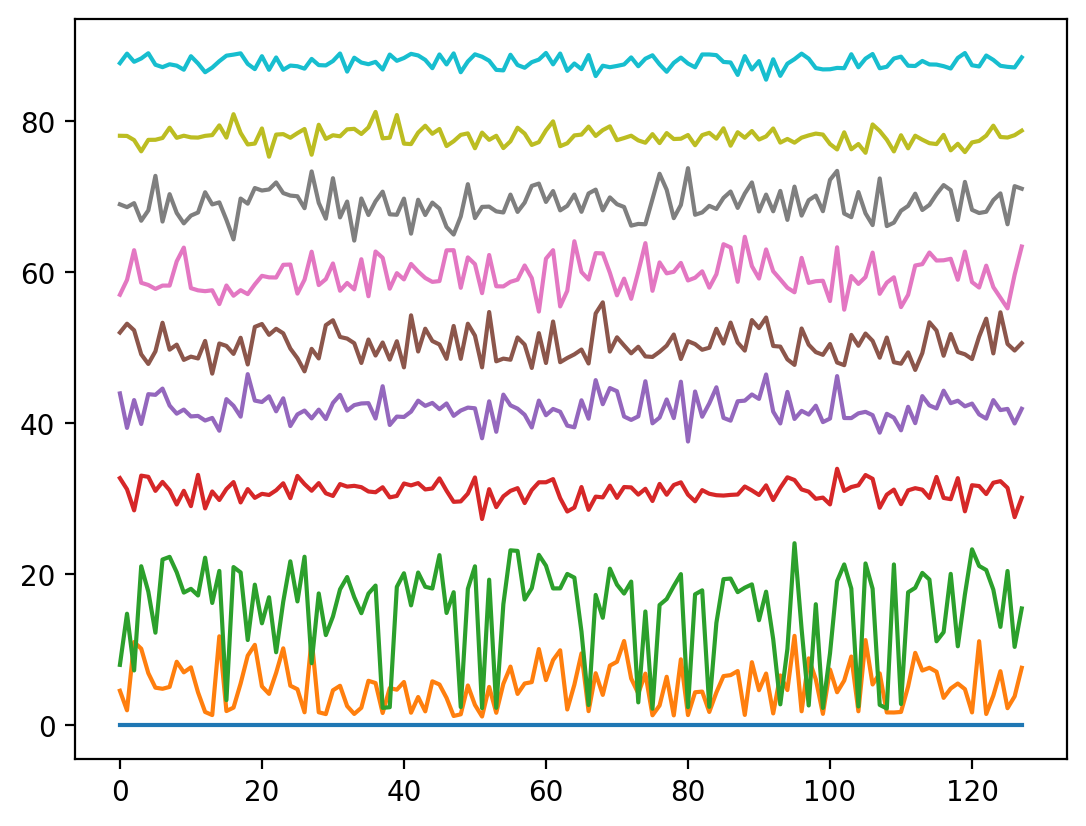

In [4]:
import matplotlib.pyplot as plt
plt.plot(ms,jnp.mean(outs[0][1].mean_err, axis=0))
plt.show()
plt.plot(jnp.mean(outs[0][1].num_comms, axis=2))
plt.show()

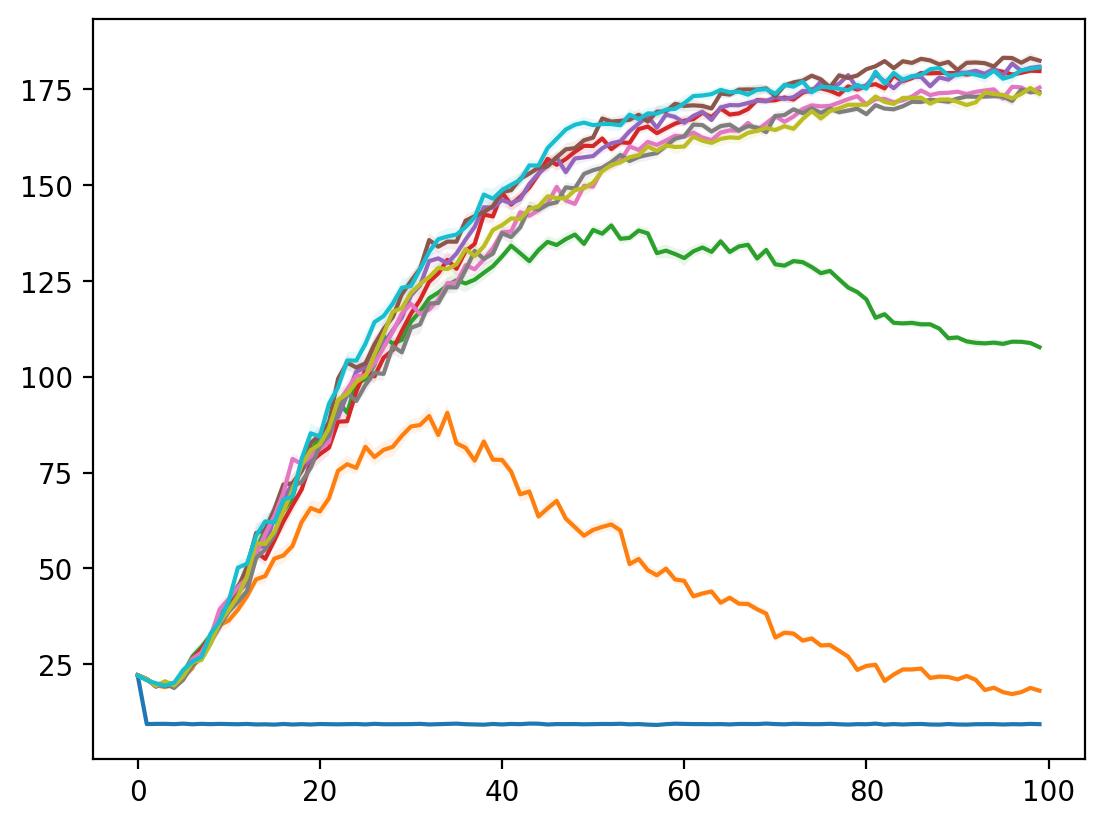

In [5]:
import matplotlib.pyplot as plt
import numpy as np
agent_means = jnp.mean(outs[1], axis=0)
trial_mean = jnp.mean(agent_means, axis=2)
trial_perc_u = jnp.percentile(agent_means, 10, axis=2)
trial_perc_l = jnp.percentile(agent_means, 90, axis=2)
x = np.arange(config["NUM_GENERATIONS"])
for i,m in enumerate(ms):
    plt.plot(x,trial_mean[i,:])
    plt.fill_between(x, trial_perc_l[i,:], trial_perc_u[i,:], alpha=0.1)
plt.show()